## Objective

The objective of this project is to explore the data and build a model to predict the electric consumption using the RESIDENTIAL ENERGY CONSUMPTION SURVEY (RECS) in 2009. 

The response variable is `KWH` which stands for kilowatt-hour.

## Import Dependencies

In [2]:
import numpy as np
import pandas as pd
from docopt import docopt
from pathlib import Path
import altair as alt

## Data Exploring

In [8]:
# raw data file
recs_df = pd.read_csv('data/recs2009_public.csv')

# `Layout file` which contains descriptive labels and formats for each data feature
layout = pd.read_csv('data/public_layout.csv')

## Train test split

It is necessary to split the raw data file into the train (20%) and
test (80%) data sets to ensure the golden rule of machine learning is not broken at the very first. During the train-test
split process, I stratified on the the categorical features `METERMICRO` and `UR` and I will explain the reasons below.

In [142]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
        recs_df,
        test_size=0.2,
        random_state=123,
        stratify=recs_df[["METROMICRO", "UR"]],
    )

In [6]:
recs_df.shape

(12083, 940)

In [7]:
layout.shape

(940, 5)

Raw data file contains 940 features and 12083 rows of observations. This data set has a large number of features so that we can consider to use appropriate feature selection algorithms to reduce model complexity in the later model fitting stage. 

In [274]:
recs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12083 entries, 0 to 12082
Columns: 940 entries, DOEID to DesignDBT1
dtypes: float64(50), int64(885), object(5)
memory usage: 86.7+ MB


In [140]:
recs_df.describe()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,PERIODKR,SCALEKER,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
count,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,...,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000
mean,6042.000000,2.628321,5.373086,14.783663,2.659604,9402.981870,4141.375238,1415.406108,4135.146983,1443.503104,...,-1.935943,-1.955392,1681.961764,139.568485,3763.728544,0.499036,5.656046,59.128693,20.256311,90.359431
std,3488.205986,1.042142,2.859366,8.195824,1.192627,5192.101419,2317.759375,1134.659475,2260.543686,1021.748722,...,0.589907,0.415810,1401.079218,264.186908,2597.754419,0.083520,6.797205,8.678293,15.337626,6.166669
min,1.000000,1.000000,1.000000,1.000000,1.000000,476.100000,0.000000,0.000000,0.000000,0.000000,...,-2.000000,-2.000000,0.000000,0.000000,0.000000,0.310000,0.000000,36.000000,-23.000000,60.000000
25%,3021.500000,2.000000,3.000000,8.000000,2.000000,6297.040000,2197.500000,561.000000,2224.000000,712.000000,...,-2.000000,-2.000000,262.500000,4.000000,1246.500000,0.430000,1.000000,52.000000,9.000000,87.000000
50%,6042.000000,3.000000,5.000000,15.000000,2.000000,7970.630000,4483.000000,1045.000000,4502.000000,1179.000000,...,-2.000000,-2.000000,1684.000000,30.000000,3878.000000,0.500000,3.000000,58.000000,18.000000,90.000000
75%,9062.500000,3.000000,7.000000,21.000000,3.000000,11330.030000,5913.000000,1897.000000,5854.000000,1842.500000,...,-2.000000,-2.000000,2662.000000,117.000000,5834.000000,0.560000,7.000000,66.000000,33.000000,94.000000
max,12083.000000,4.000000,10.000000,27.000000,5.000000,95779.140000,12525.000000,5480.000000,13346.000000,5357.000000,...,5.000000,3.000000,7623.000000,1884.000000,11567.000000,0.800000,34.000000,89.000000,67.000000,118.000000


In [273]:
recs_df.isnull().sum().sum() # no missing values for all feature columns

0

Most of the features are of numerical data type(`int64` and `float64` types). It might be better to convert them to `int32` and `float32` to save space in the memory and speed up the model training process when we have a really large number of columns and rows.


Some features have large values such as `GND_HDD65` which stands for `Heating degree days of ground temperature in 2009` and some features have really small values like `WSF` which stands for `weather & shielding factor for the housing unit`. As a result, we may consider to apply standard scaler to handle highly varying magnitudes or values of features. 

In [133]:
layout[layout['Variable Type']=='Character']

,Variable Name,Variable Label,Variable Order in File,Variable Type,Length
0,DOEID,Unique identifier for each respondent,1,Character,5
12,METROMICRO,Housing unit in Census Metropolitan Statistica...,13,Character,5
13,UR,Housing unit classified as urban or rural by C...,14,Character,1
833,ZTOTSQFT,Imputation flag for TOTSQFT,834,Character,1
834,ZTOTSQFT_EN,Imputation flag for TOTSQFT_EN,835,Character,1
835,ZTOTHSQFT,Imputation flag for TOTHSQFT,836,Character,1
836,ZTOTUSQFT,Imputation flag for TOTUSQFT,837,Character,1
837,ZTOTCSQFT,Imputation flag for TOTCSQFT,838,Character,1
838,ZTOTUCSQFT,Imputation flag for TOTUCSQFT,839,Character,1
931,IECC_Climate_Pub,International Energy Conservation Code (IECC) ...,932,Character,15


In [19]:
recs_df['METROMICRO'].value_counts()

METRO    10302
MICRO     1109
NONE       672
Name: METROMICRO, dtype: int64

In [20]:
recs_df['UR'].value_counts()

U    9656
R    2427
Name: UR, dtype: int64

In [22]:
recs_df['IECC_Climate_Pub'].value_counts()

4A               2703
5A               2402
1A-2A            1740
3B-4B            1523
3A               1235
6A-6B             971
5B-5C             476
3C                368
4C                312
2B                209
7A-7B-7AK-8AK     144
Name: IECC_Climate_Pub, dtype: int64


The number of categorical features is 3 which are `METERMICRO`, `UR` and `IECC_Climate_Pub` respectively.

By taking a closer look of certain categorical features, it seems that `METERMICRO` and `UR` has class imbalance issues. 

The number of housing unit in Census Metropolitan Statistical Area is almost 9 times the number of housing unit in Census Micropolitan Statistical Area. 

`METERMICRO` 

- METRO: Housing unit in Census Metropolitan Statistical Area

- MICRO: Housing unit in Census Micropolitan Statistical Area

- NONE: Housing unit in neither

The number of housing unit classified as urban is almost 4 times the number of housing unit classified as rural.

`UR` 

- Urban: Housing unit classified as urban

- Rural: Housing unit classified as rural

In this case, we can stratify on these features to mitigate the class imbalances in the process of train-test split because I would like to ensure that the training and test sets have the similar proportion of the features of interest as in the raw data set; therefore, the models would not result in imbalanced predictive powers on different categories.

In [135]:
imp_flag = layout.loc[layout['Variable Label'].str.contains("Imputation flag", case=False)]

We will need to remove the columns of `imputation flag` as they are replicate and irrelevant.

In [160]:
train_df = train_df.drop(columns=imp_flag['Variable Name'])

In [161]:
test_df = test_df.drop(columns=imp_flag['Variable Name'])

In [177]:
train_df

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1,kwh_log
8036,8037,1,1,1,2,11174.23,7819,254,7655,417,...,6A-6B,4352,0,7986,0.55,2,48,-4,81,8.789355
4688,4689,3,7,21,2,8542.97,1254,3664,1513,3092,...,1A-2A,137,870,0,0.46,8,71,34,94,8.421343
6078,6079,2,4,10,2,5126.84,7850,426,7554,678,...,6A-6B,3918,0,7132,0.60,1,50,-4,85,9.530611
8406,8407,2,4,10,2,4697.21,8095,442,8002,614,...,6A-6B,4521,0,7701,0.59,1,45,-4,85,9.726452
7238,7239,4,10,26,2,6552.25,1177,1342,1239,1464,...,3B-4B,0,55,1072,0.38,1,65,37,90,8.491260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9674,9675,2,4,12,2,2935.68,5306,912,5131,1280,...,4A,2378,13,4811,0.51,4,57,11,89,8.648748
1291,1292,3,7,20,5,16004.67,1368,3011,1490,2809,...,1A-2A,177,377,340,0.42,18,71,34,89,9.139703
11030,11031,2,3,9,2,7960.93,8841,209,8599,343,...,6A-6B,4705,6,9395,0.56,1,48,-7,86,9.178437
3910,3911,3,5,17,2,6612.77,625,3548,555,3320,...,1A-2A,33,255,0,0.37,25,69,43,93,9.964018


## Exploratory Data Analysis

I would like to use the train data set to do some exploratory data analysis on important features. 

### Target feature: KWH

In [162]:
train_df['KWH'].describe()

count     9666.000000
mean     11264.357438
std       7503.994404
min         17.000000
25%       5846.000000
50%       9610.000000
75%      14757.750000
max      77622.000000
Name: KWH, dtype: float64

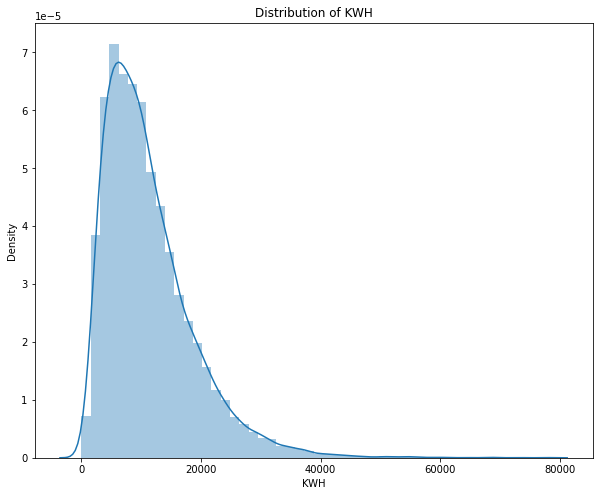

In [172]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[10,8])
sns.distplot(train_df['KWH'],ax=ax).set_title('Distribution of KWH');

We can see that the mean is 11264 KWH and the standard deviation is 7504 KWH for the train set. The standard deviation of `KWH` is quite high which may indicate that the data points are largely spread out and far away from the mean.

The density plot of `kWH` shows a highly right skewed distribution. To mitigate the skewness, the most common way is to apply a log transformation. 

In [164]:
train_df['kwh_log'] = np.log(train_df['KWH'])
test_df['kwh_log'] = np.log(test_df['KWH'])

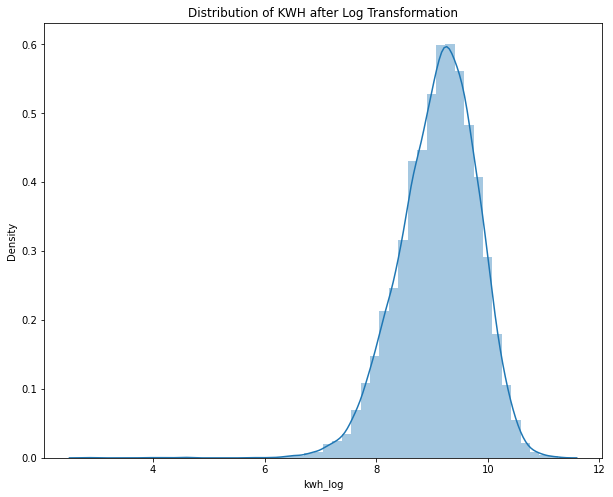

In [165]:
fig, ax = plt.subplots(figsize=[10,8])
sns.distplot(train_df['kwh_log'],ax=ax).set_title('Distribution of KWH after Log Transformation');

### Feature Selection 

#### numerical features

We have 940 columns in the original data set and dropped to 582 after removing the columns that contains 'imputation flag'. Among the 582 features, 3 of them are categorical features, 578 are numerical features and 1 of them is the target feature - KWH). Since we have so many features, it is not feasible to do EDA for all of them.  

If time is allowed, it is necessary to go through each feature and remove features with replicate weights and irrelevant features and also organize the remaining features into different categories. For example, `OVEN`(Number of separate ovens), `TVCOLOR`(Number of televisions used) might be good to be grouped as the `Appliance` category. 

Given the limited time I have, I would like to use `f_regression` that ranks features in the same order if all the features are positively correlated with the target and in this case, it is recommended as a feature selection criterion to identify potentially predictive numerical features, regardless of the association's sign with the target variable. Then, I would use `SelectKBest` function to select the top 30 best features that are most highly correlated with `KWH` using `f_regression`. 

In [166]:
X_train_num = train_df.drop(columns=['KWH','kwh_log','METROMICRO','UR','IECC_Climate_Pub','NOCRCASH','NKRGALNC'])
y_train = train_df["KWH"]

# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# generate dataset
# define feature selection
fs = SelectKBest(score_func=f_regression, k=30)
# apply feature selection
X_selected = fs.fit_transform(X_train_num, y_train)
print(X_selected.shape)


(9666, 30)


In [167]:
cols = fs.get_support(indices=True)

In [168]:
X_train_num_selected = X_train_num.iloc[:,cols]

In [169]:
X_train_num_selected.columns

Index(['BEDROOMS', 'NCOMBATH', 'TOTROOMS', 'ACROOMS', 'TOTCSQFT', 'KWHSPH',
       'KWHCOL', 'KWHWTH', 'KWHRFG', 'KWHOTH', 'BTUEL', 'BTUELSPH', 'BTUELCOL',
       'BTUELWTH', 'BTUELRFG', 'BTUELOTH', 'DOLLAREL', 'DOLELSPH', 'DOLELCOL',
       'DOLELWTH', 'DOLELRFG', 'DOLELOTH', 'TOTALBTUCOL', 'TOTALBTURFG',
       'TOTALBTUOTH', 'TOTALDOL', 'TOTALDOLCOL', 'TOTALDOLWTH', 'TOTALDOLRFG',
       'TOTALDOLOTH'],
      dtype='object')

In [170]:
X_train_num_selected.merge(y_train,left_index=True, right_index=True)

,BEDROOMS,NCOMBATH,TOTROOMS,ACROOMS,TOTCSQFT,KWHSPH,KWHCOL,KWHWTH,KWHRFG,KWHOTH,...,DOLELOTH,TOTALBTUCOL,TOTALBTURFG,TOTALBTUOTH,TOTALDOL,TOTALDOLCOL,TOTALDOLWTH,TOTALDOLRFG,TOTALDOLOTH,KWH
8036,3,1,6,-2,173,0.00,24.63,0.00,395.32,6144.05,...,935.09,84,1349,20963,2143,4,292,60,935,6564
4688,2,1,5,-2,541,0.00,1184.30,0.00,505.00,2853.71,...,283.30,4041,1723,13139,674,118,94,50,332,4543
6078,5,1,9,-2,224,733.63,332.53,3202.58,921.75,8584.52,...,612.60,1135,3145,34644,2416,24,229,66,708,13775
8406,4,1,8,-2,714,0.00,1130.32,0.00,1574.57,14050.11,...,1080.13,3857,5372,84907,2906,87,323,121,1394,16755
7238,3,1,5,5,1596,668.09,798.46,0.00,463.01,2942.44,...,382.30,2724,1580,35614,1247,104,319,60,677,4872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9674,3,2,6,6,1800,0.00,1312.39,0.00,690.13,3700.49,...,432.91,4478,2355,12626,1588,154,246,81,433,5703
1291,1,1,3,3,726,1912.61,2323.12,1707.89,1016.68,2357.70,...,201.16,7926,3469,8044,795,198,146,87,201,9318
11030,3,3,7,7,2814,0.00,233.06,0.00,739.51,8713.43,...,1145.18,795,2523,29731,2356,31,307,97,1145,9686
3910,3,2,7,7,1449,1098.47,4310.31,2816.25,1257.32,11765.65,...,1518.88,14707,4290,40144,2743,556,364,162,1519,21248


For the 30 numerical features that were selected by `f_regression`, I applied multicollinearity analysis and would like to manually features that are highly correlated with each others.

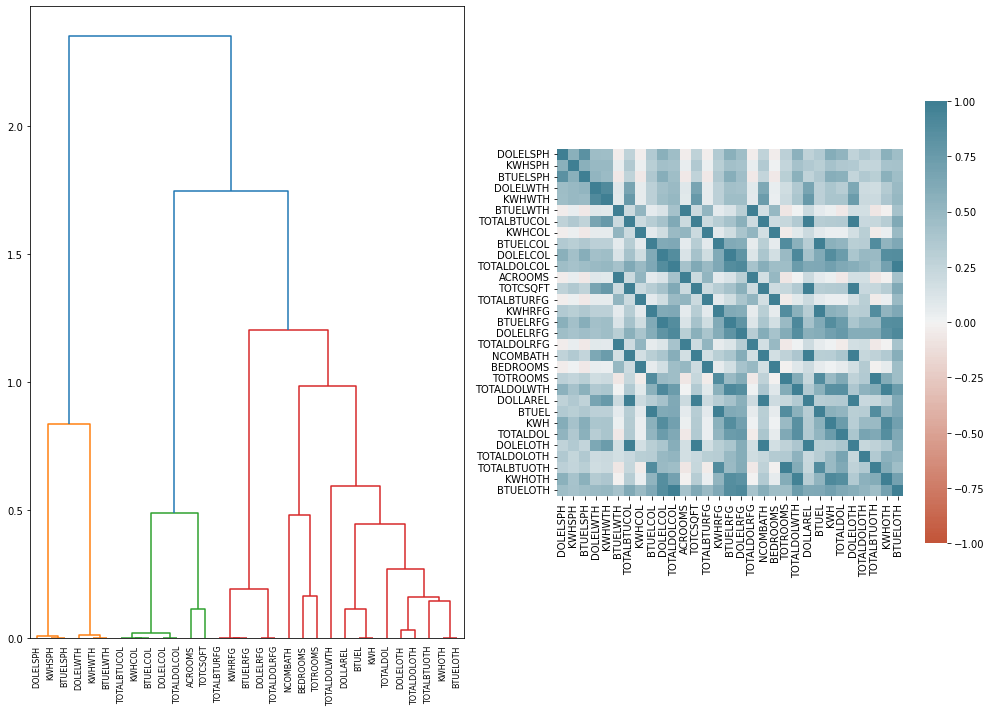

In [278]:
# feature selection

train_num_df = X_train_num_selected.merge(y_train,left_index=True, right_index=True)
    
num_feat = train_num_df.columns.tolist()


# numerical features
plt.rcParams.update({'font.size': 10})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))
corr = spearmanr(train_num_df).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
corr = np.nan_to_num(corr)
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
dist_linkage, labels=train_num_df.columns.values.tolist(), ax=ax1, leaf_rotation=90
    )
dendro_idx = np.arange(0, len(dendro["ivl"]))

cbar_kws = {
        "orientation": "vertical",
        "shrink": 0.7,
    }  # color bar keyword arguments

ax2 = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        cbar_kws=cbar_kws
    )
# ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx + 0.5)
ax2.set_yticks(dendro_idx + 0.5)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"],rotation="horizontal")
fig.tight_layout()

As we can see from the dendrogram above on the left side, we can see that `KWHSPH`, `BTUELSPH` and `DOLELSPH` are highly correlated with each other, so does `KWHWTH` & `BTUELWTH`,`KWHCOL`& `BTUELCOL`,`DOLELCOL` & `TOTALDOLCOL`, `KWHRFG` & `BTUELRFG`, `DOLELRFG` & `TOTALDOLERFG` and `KWHOTH` & `BTUELOTH`. They are actually conveying the same information which may hinder the model performance and mislead the interpretation of feature importance. So, we need to manually dropped one of them. 

In addition, target feature `KWH` is highly correlated with `BTUEL` (they are different units of energy used).

In [279]:
train_num_df = train_num_df.drop(
    columns=[
        "BTUELSPH",
        "BTUELCOL",
        "TOTALDOLCOL",
        "BTUELRFG",
        "TOTALDOLRFG",
        "BTUELOTH",
        "BTUELWTH",
        "BTUEL",
        'TOTALBTUCOL',
        'TOTALBTURFG'
    ]
)

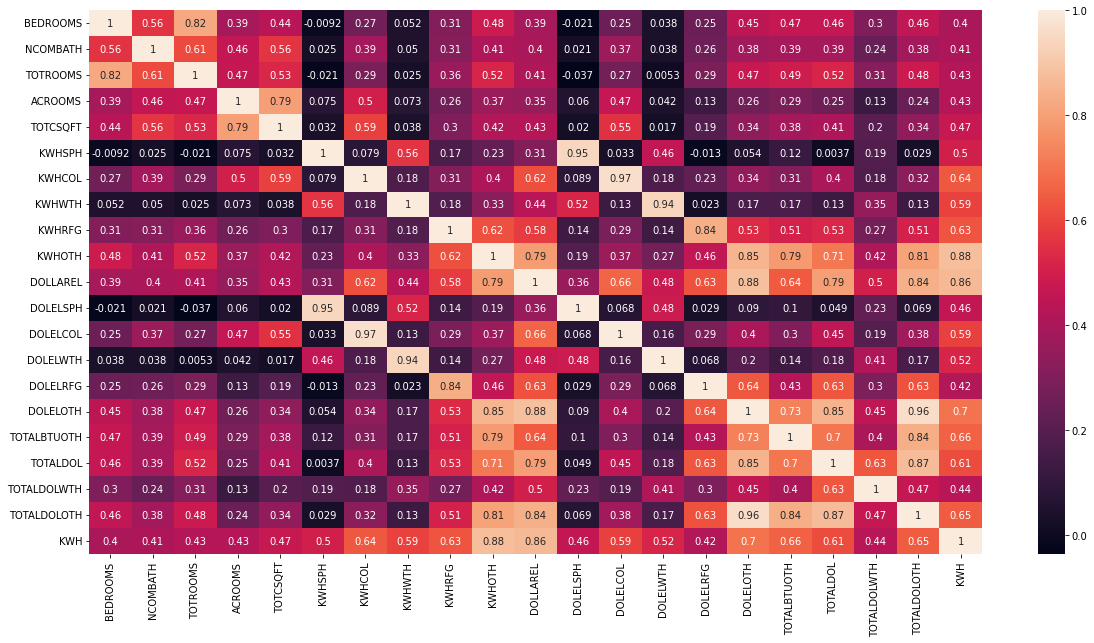

In [280]:
plt.figure(figsize = (20,10))
heatmap = sns.heatmap(train_num_df.corr(), annot = True)

In this case, the features that have high correlation (>0.6) with `KWH` are:

- `KWHOTH`: Electricity usage for other purposes (all end-uses except SPH, COL, WTH, and RFG), in kilowatt-hours, 2009

- `KWHCOL`: Electricity usage for air-conditioning, central and window/wall (room), in kilowatt-hours, 2009

- `KWHRFG`: Electricity usage for refrigerators, in kilowatt-hours, 2009

- `KWHWTH`: Electricity usage for water heating, in kilowatt-hours, 2009

- `DOLLAREL`: Total Electricity cost, in whole dollars, 2009

- `DOLELOTH`: Electricity cost for other purposes (all end-uses except SPH, COL, WTH, and RFG), in wholedollars, 2009

- `TOTALDOL`: Total cost, in whole dollars, 2009

- `TOTALDOLOTH`: Total cost for appliances, electronics, lighting, and miscellaneous uses, in whole dollars, 2009

It seems that the electricity usage and cost are important indicators for predicting `KWH` which stands for `Total Site Electricity usage, in kilowatt-hours, 2009`. 

Additionally, features related to `Technology and Space` such as `BEDROOMS`(number of rooms except bathrooms), `NCOMBATH`(number of full bathrooms), `TOTROOMS`(total number of rooms in the housing unit), `ACROOMS`(number of rooms cooled), `TOTSQFT`(total square footage (includes all attached garages, all basements, and finished/heated/cooled attics)) are also important indicators in electricity usage.

#### Categorical features

In [157]:
X_train_cat = train_df[["UR","METROMICRO",'IECC_Climate_Pub']]

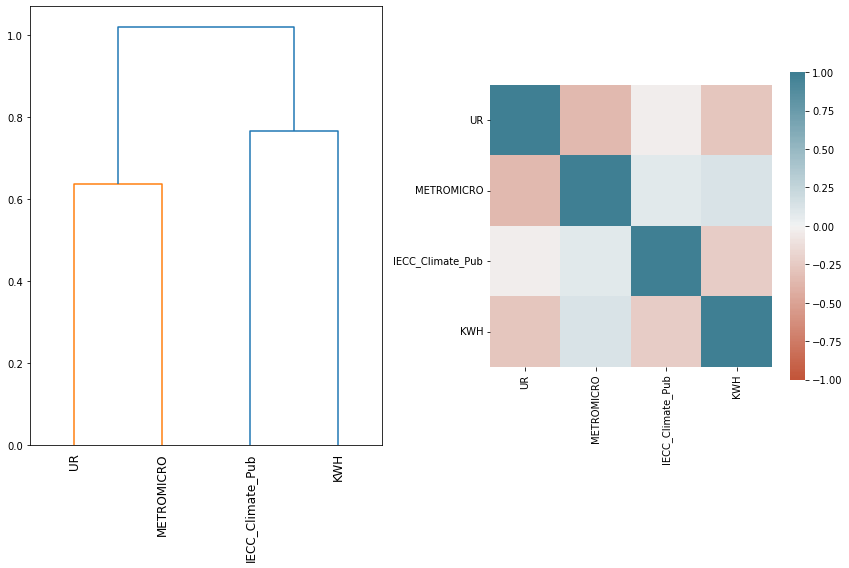

In [158]:
train_cat_df = X_train_cat.merge(y_train,left_index=True, right_index=True)
    
# categorical features
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(train_cat_df).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
corr = np.nan_to_num(corr)
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
        dist_linkage, labels=train_cat_df.columns.values.tolist(), ax=ax1, leaf_rotation=90
    )
dendro_idx = np.arange(0, len(dendro["ivl"]))

cbar_kws = {
        "orientation": "vertical",
        "shrink": 0.7,
    }  # color bar keyword arguments

ax2 = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        cbar_kws=cbar_kws
    )
#ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx + 0.5)
ax2.set_yticks(dendro_idx + 0.5)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"],rotation="horizontal")
fig.tight_layout()

It seems like the categorical features do not have correlation with `KWH` and the multicollinearity analysis shows that each feature is not highly correlated with each other, so we will keep all the three features.

### EDA for important features explored above

In [190]:
train_num_df.columns

Index(['BEDROOMS', 'NCOMBATH', 'TOTROOMS', 'ACROOMS', 'TOTCSQFT', 'KWHSPH',
       'KWHCOL', 'KWHWTH', 'KWHRFG', 'KWHOTH', 'DOLLAREL', 'DOLELSPH',
       'DOLELCOL', 'DOLELWTH', 'DOLELRFG', 'DOLELOTH', 'TOTALBTUCOL',
       'TOTALBTURFG', 'TOTALBTUOTH', 'TOTALDOL', 'TOTALDOLWTH', 'TOTALDOLOTH',
       'KWH'],
      dtype='object')

In [191]:
train_cat_df.columns

Index(['UR', 'METROMICRO', 'IECC_Climate_Pub', 'KWH'], dtype='object')

In [285]:
# a train_df with important features

# train_df_selected = train_df[['DOEID','BEDROOMS', 'NCOMBATH', 'TOTROOMS', 'ACROOMS', 'TOTCSQFT', 'KWHSPH',
#        'KWHCOL', 'KWHWTH', 'KWHRFG', 'KWHOTH', 'DOLLAREL', 'DOLELSPH',
#        'DOLELCOL', 'DOLELWTH', 'DOLELRFG', 'DOLELOTH', 'TOTALBTUCOL',
#        'TOTALBTURFG', 'TOTALBTUOTH', 'TOTALDOL', 'TOTALDOLWTH', 'TOTALDOLOTH',
#         'UR', 'METROMICRO', 'IECC_Climate_Pub','KWH']]

### Category of Room type and Technology versus KWH

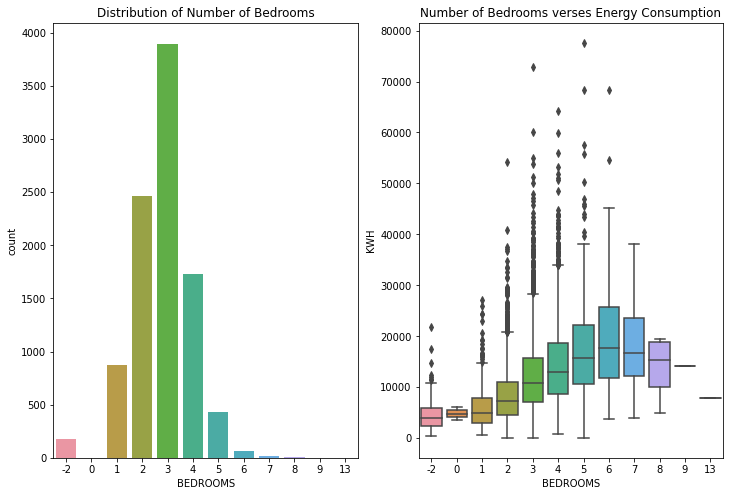

In [282]:
plt.figure(figsize=(12,8))
plt.subplot(121)
ax_bedroom = sns.countplot(x='BEDROOMS', data=train_df)
ax_bedroom.set_title("Distribution of Number of Bedrooms")


plt.subplot(122)
ax_bedroom = sns.boxplot(x ="BEDROOMS",y="KWH", data=train_df)
ax_bedroom.set_title("Number of Bedrooms verses Energy Consumption")

plt.show()

Most housing unit has 3 bedrooms, and the more the number of bedrooms, the higher the energy consumption in KWH.

There is a `-2` category that may require further investigation. Data instances that has `-2` bedroom might need to be dropped.

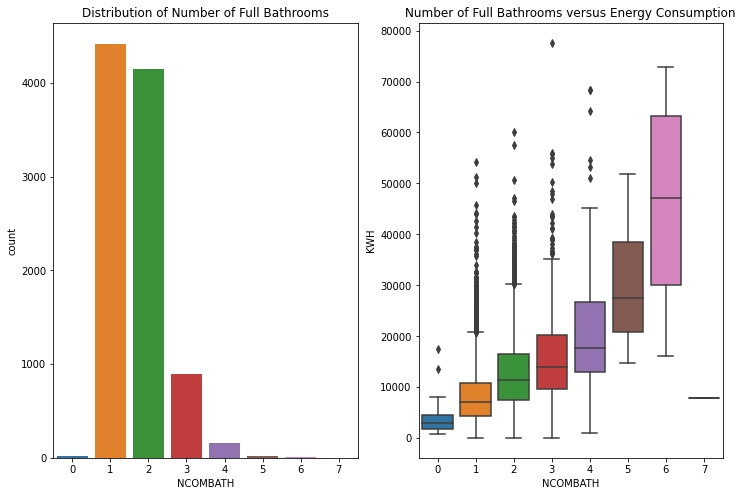

In [281]:
plt.figure(figsize=(12,8))
plt.subplot(121)
ax_bedroom = sns.countplot(x='NCOMBATH', data=train_df)
ax_bedroom.set_title("Distribution of Number of Full Bathrooms")


plt.subplot(122)
ax_bedroom = sns.boxplot(x ="NCOMBATH",y="KWH", data=train_df)
ax_bedroom.set_title("Number of Full Bathrooms versus Energy Consumption")

plt.show()

Most housing unit has 1 or 2 complete bathrooms, and the more the number of bathrooms, the higher the energy consumption in KWH.

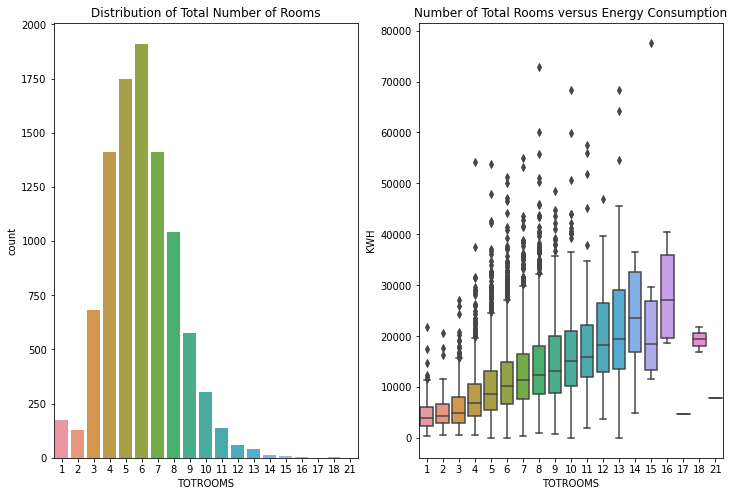

In [283]:
plt.figure(figsize=(12,8))
plt.subplot(121)
ax_bedroom = sns.countplot(x='TOTROOMS', data=train_df)
ax_bedroom.set_title("Distribution of Total Number of Rooms")


plt.subplot(122)
ax_bedroom = sns.boxplot(x ="TOTROOMS",y="KWH", data=train_df)
ax_bedroom.set_title("Number of Total Rooms versus Energy Consumption")

plt.show()

Most housing unit has 5 or 6 rooms, and there is a clear pattern that the more the number of rooms in total, the higher the energy consumption in KWH.

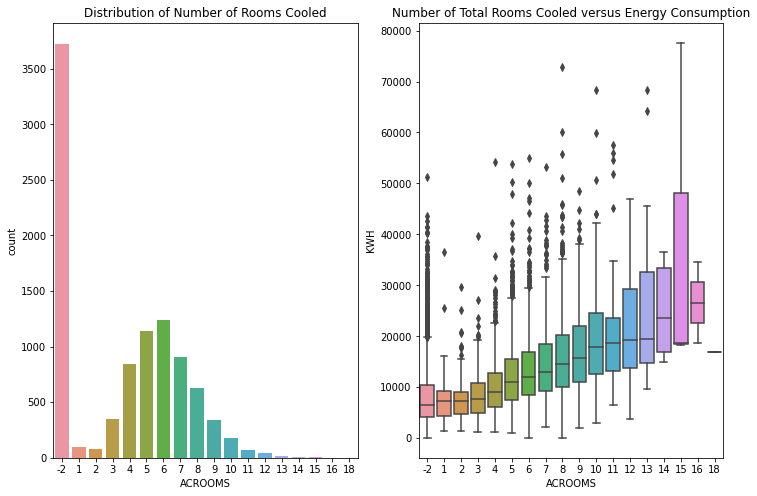

In [284]:
plt.figure(figsize=(12,8))
plt.subplot(121)
ax_bedroom = sns.countplot(x='ACROOMS', data=train_df)
ax_bedroom.set_title("Distribution of Number of Rooms Cooled")


plt.subplot(122)
ax_bedroom = sns.boxplot(x ="ACROOMS",y="KWH", data=train_df)
ax_bedroom.set_title("Number of Total Rooms Cooled versus Energy Consumption")

plt.show()

There is a `-2` category that may require further investigation. Data instances that has `-2` rooms cooled might need to be dropped. 

there is a clear pattern that the more the number of rooms cooled, the higher the energy consumption in KWH.

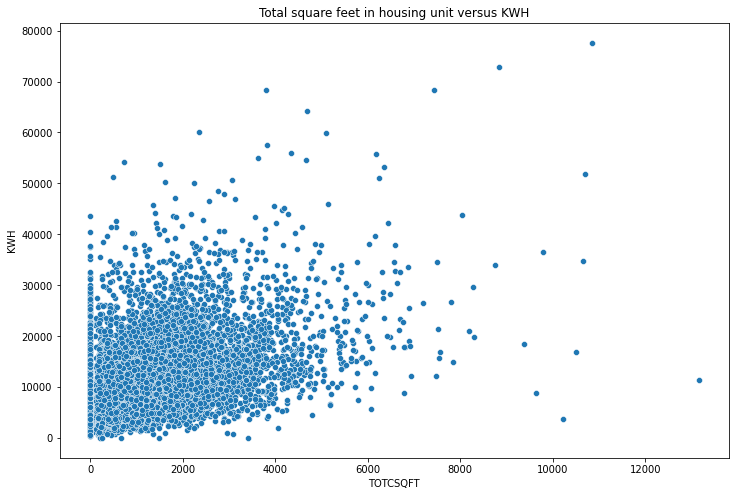

In [271]:
fig, ax = plt.subplots(figsize=[12,8])

sns.scatterplot(data=train_df, x="TOTCSQFT", y="KWH")
plt.title('Total square feet in housing unit versus KWH')
plt.show()

There is a relatively weak positive association between total square feet in housing unit and `KWH`

### Categorical features versus KWH

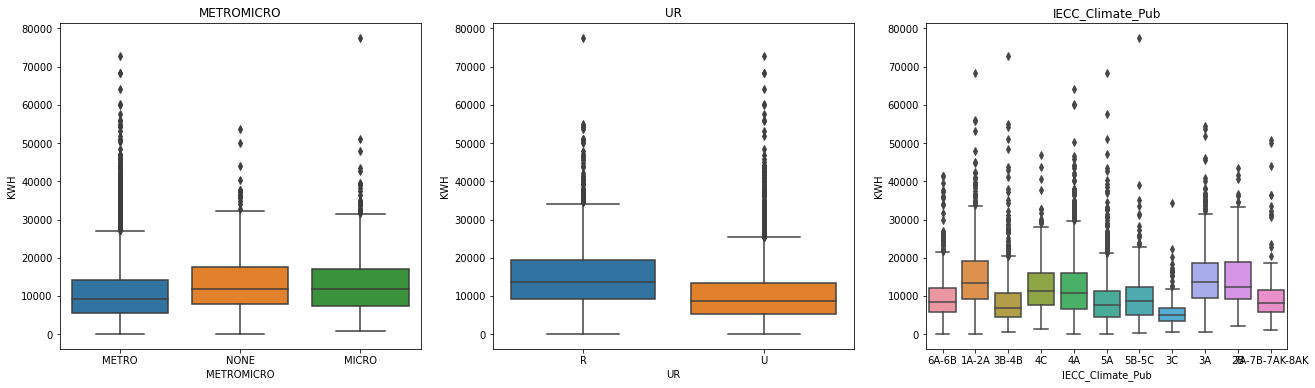

In [241]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))

sns.boxplot(x='METROMICRO', y='KWH', data=train_df, ax=ax1)
ax1.set_title("METROMICRO")

sns.boxplot(x='UR', y='KWH', data=train_df, ax=ax2)
ax2.set_title("UR")

sns.boxplot(x='IECC_Climate_Pub', y='KWH', data=train_df, ax=ax3)
ax3.set_title("IECC_Climate_Pub")

plt.show()

### Energy consumption & cost versus KHW

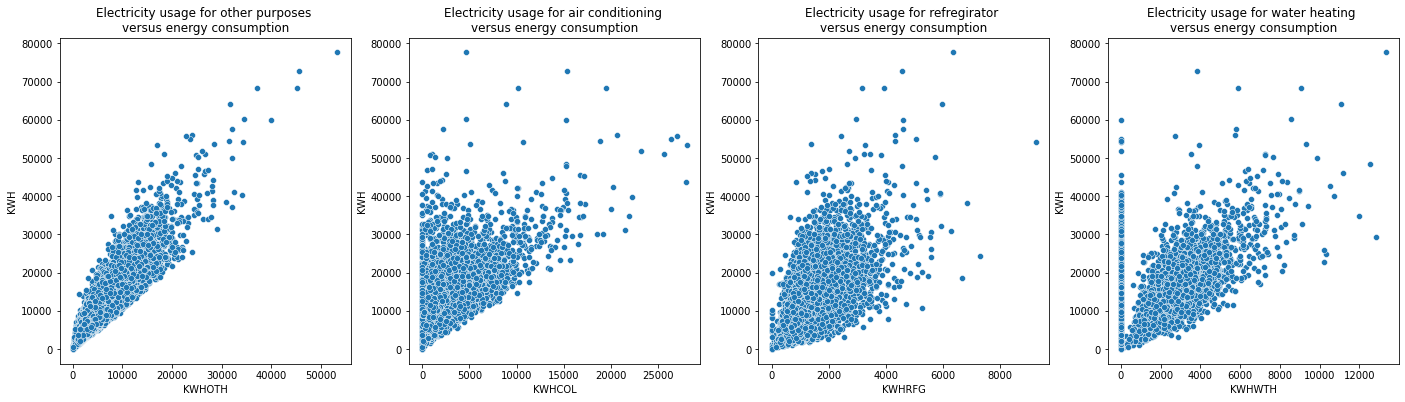

In [252]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))

sns.scatterplot(data=train_df, x="KWHOTH", y="KWH",ax=ax1)
ax1.set_title('Electricity usage for other purposes \nversus energy consumption')

sns.scatterplot(data=train_df, x="KWHCOL", y="KWH",ax=ax2)
ax2.set_title('Electricity usage for air conditioning \nversus energy consumption')

sns.scatterplot(data=train_df, x="KWHRFG", y="KWH",ax=ax3)
ax3.set_title('Electricity usage for refregirator \nversus energy consumption')

sns.scatterplot(data=train_df, x="KWHWTH", y="KWH",ax=ax4)
ax4.set_title('Electricity usage for water heating \nversus energy consumption')

plt.show()

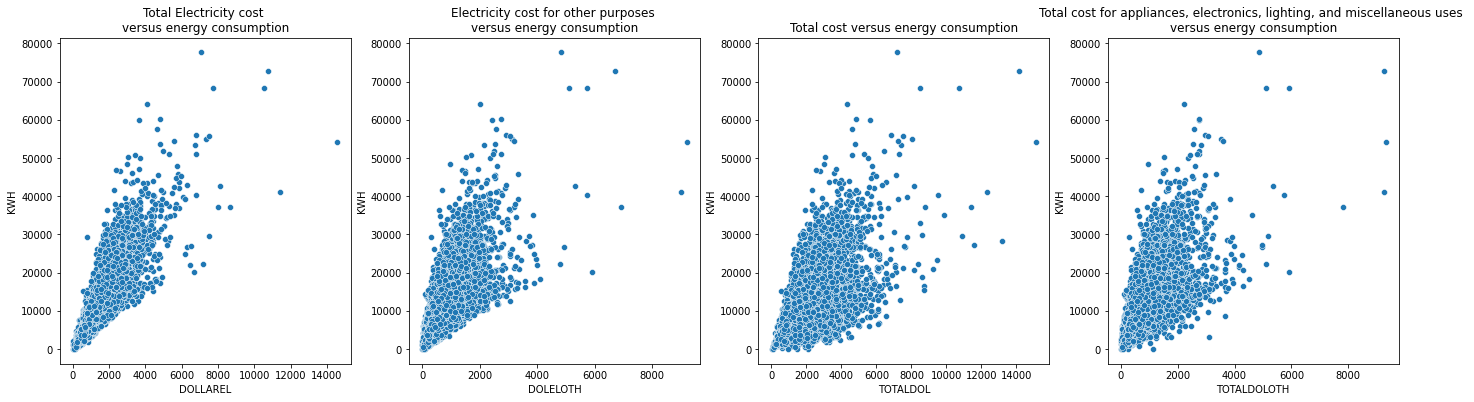

In [263]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))

sns.scatterplot(data=train_df, x="DOLLAREL", y="KWH",ax=ax1)
ax1.set_title('Total Electricity cost \nversus energy consumption')

sns.scatterplot(data=train_df, x="DOLELOTH", y="KWH",ax=ax2)
ax2.set_title('Electricity cost for other purposes \nversus energy consumption')

sns.scatterplot(data=train_df, x="TOTALDOL", y="KWH",ax=ax3)
ax3.set_title('Total cost versus energy consumption')

sns.scatterplot(data=train_df, x="TOTALDOLOTH", y="KWH",ax=ax4)
ax4.set_title('Total cost for appliances, electronics, lighting, and miscellaneous uses \nversus energy consumption')

plt.show()

Each electricity usage and cost has a clear positive correlation with `KWH`. All the plots above shows some outliers with `KWH` being greater than 70000 which might be better dropped. 

### Feature Engineering

In [289]:
### the percentage of cost for other purposes to the total electricity cost, in whole dollars, 2009

train_df['pct_oth_cost'] = (train_df['DOLELOTH'].div(train_df['DOLLAREL'].values)) * 100
test_df['pct_oth_cost'] = (test_df['DOLELOTH'].div(test_df['DOLLAREL'].values)) * 100

In [287]:
train_df['pct_oth_cost'].corr(train_df['KWH'])

-0.18316517132914897

### Model fitting for original data set versus data set with selected features